In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('default')
sns.set_palette('deep')
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 10

## 1. Data Loading

In [2]:
# Load all datasets
train_df = pd.read_csv('../data/raw/train.csv', parse_dates=['date'])
holiday_df = pd.read_csv('../data/raw/holidays_events.csv', parse_dates=['date'])
oil_df = pd.read_csv('../data/raw/oil.csv', parse_dates=['date'])
stores_df = pd.read_csv('../data/raw/stores.csv')
transactions_df = pd.read_csv('../data/raw/transactions.csv', parse_dates=['date'])

## 2. Sales Analysis

In [3]:
# Create temporal features
train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.day
train_df['dayofweek'] = train_df['date'].dt.dayofweek

# Day names for better interpretation
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
train_df['day_name'] = train_df['dayofweek'].map(lambda x: day_names[x])

# Store performance analysis
store_performance = train_df.groupby('store_nbr').agg({
    'sales': ['sum', 'mean', 'std', 'count'],
    'onpromotion': 'mean'
}).round(2)

store_performance.columns = ['Total_Sales', 'Avg_Sales', 'Sales_Std', 'Records_Count', 'Promo_Rate']
store_performance = store_performance.reset_index()

# Merge with store information
store_analysis = store_performance.merge(stores_df, left_on='store_nbr', right_on='store_nbr', how='left')


### 2.1 Sales Distribution

Text(0, 0.5, 'Frequency')

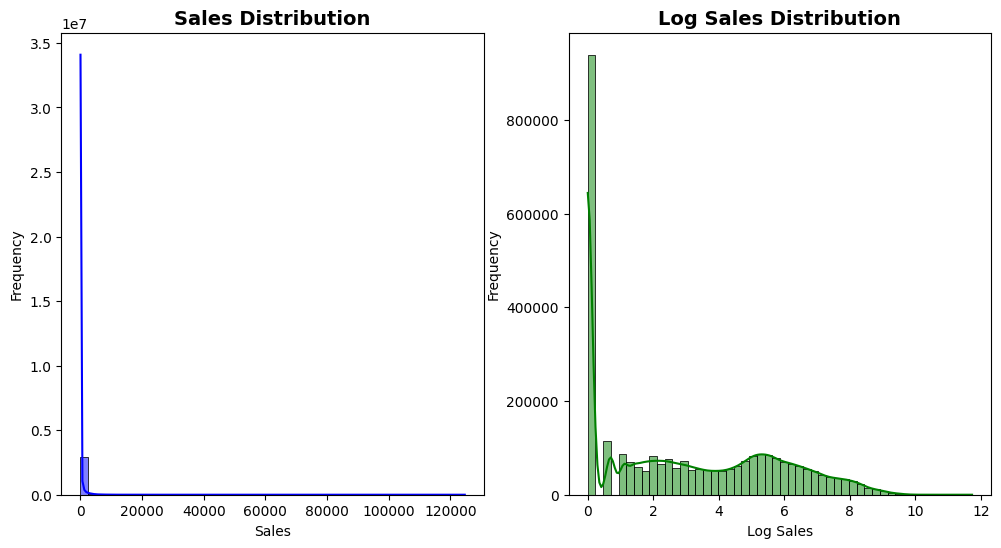

In [4]:
# Sales trends over time
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# sales distribution
sns.histplot(train_df['sales'], bins=50, kde=True, ax=axes[0], color='blue')
axes[0].set_title('Sales Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Sales')
axes[0].set_ylabel('Frequency')

# log sales distribution
train_df['log_sales'] = np.log1p(train_df['sales'])
sns.histplot(train_df['log_sales'], bins=50, kde=True, ax=axes[1], color='green')
axes[1].set_title('Log Sales Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Log Sales')
axes[1].set_ylabel('Frequency')


### 2.2 Sales per time

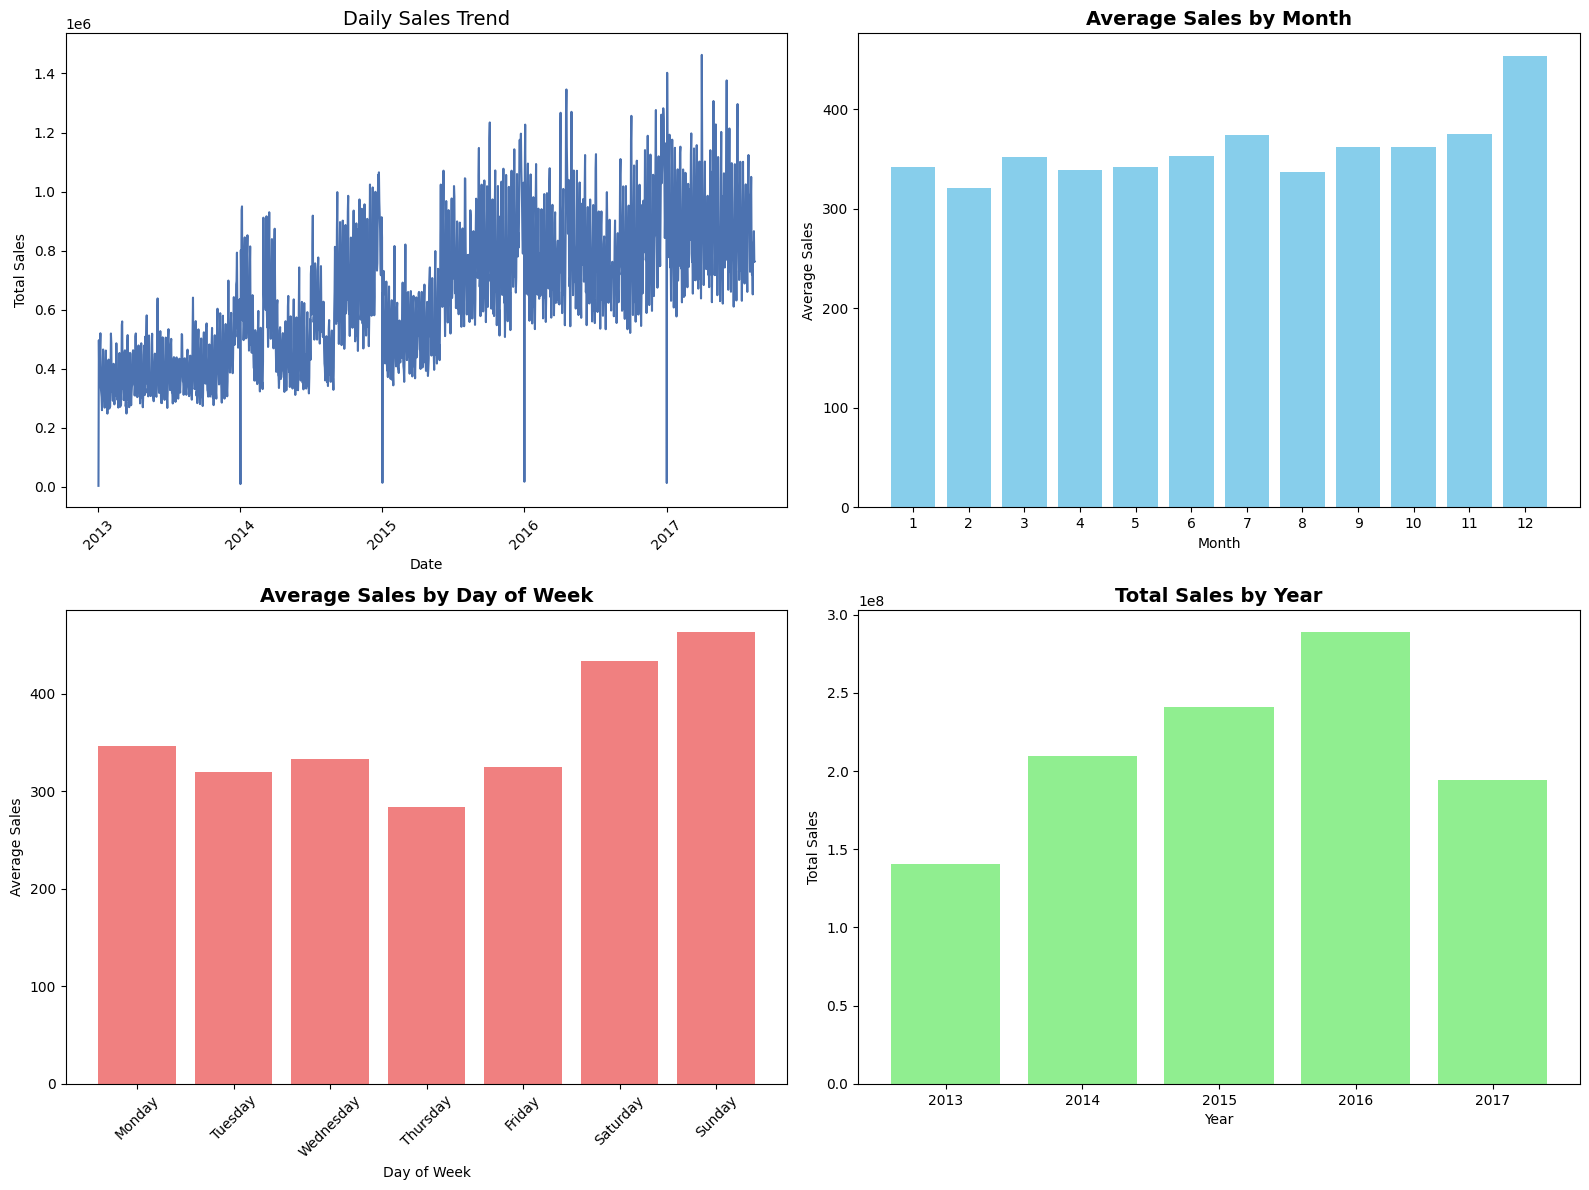

In [5]:
# Sales trends over time
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Daily sales trend
daily_sales = train_df.groupby('date')['sales'].sum()
axes[0,0].plot(daily_sales.index, daily_sales.values)
axes[0,0].set_title('Daily Sales Trend', fontsize=14)
axes[0,0].set_xlabel('Date')
axes[0,0].set_ylabel('Total Sales')
axes[0,0].tick_params(axis='x', rotation=45)

# Monthly sales pattern
monthly_sales = train_df.groupby('month')['sales'].mean()
axes[0,1].bar(monthly_sales.index, monthly_sales.values, color='skyblue')
axes[0,1].set_title('Average Sales by Month', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Month')
axes[0,1].set_ylabel('Average Sales')
axes[0,1].set_xticks(range(1, 13))

# Day of week pattern
dow_sales = train_df.groupby('day_name')['sales'].mean().reindex(day_names)
axes[1,0].bar(range(len(dow_sales)), dow_sales.values, color='lightcoral')
axes[1,0].set_title('Average Sales by Day of Week', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Day of Week')
axes[1,0].set_ylabel('Average Sales')
axes[1,0].set_xticks(range(len(day_names)))
axes[1,0].set_xticklabels(day_names, rotation=45)

# Yearly sales trend
yearly_sales = train_df.groupby('year')['sales'].sum()
axes[1,1].bar(yearly_sales.index, yearly_sales.values, color='lightgreen')
axes[1,1].set_title('Total Sales by Year', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Year')
axes[1,1].set_ylabel('Total Sales')

plt.tight_layout()
plt.show()

### 2.3 sales per another factors

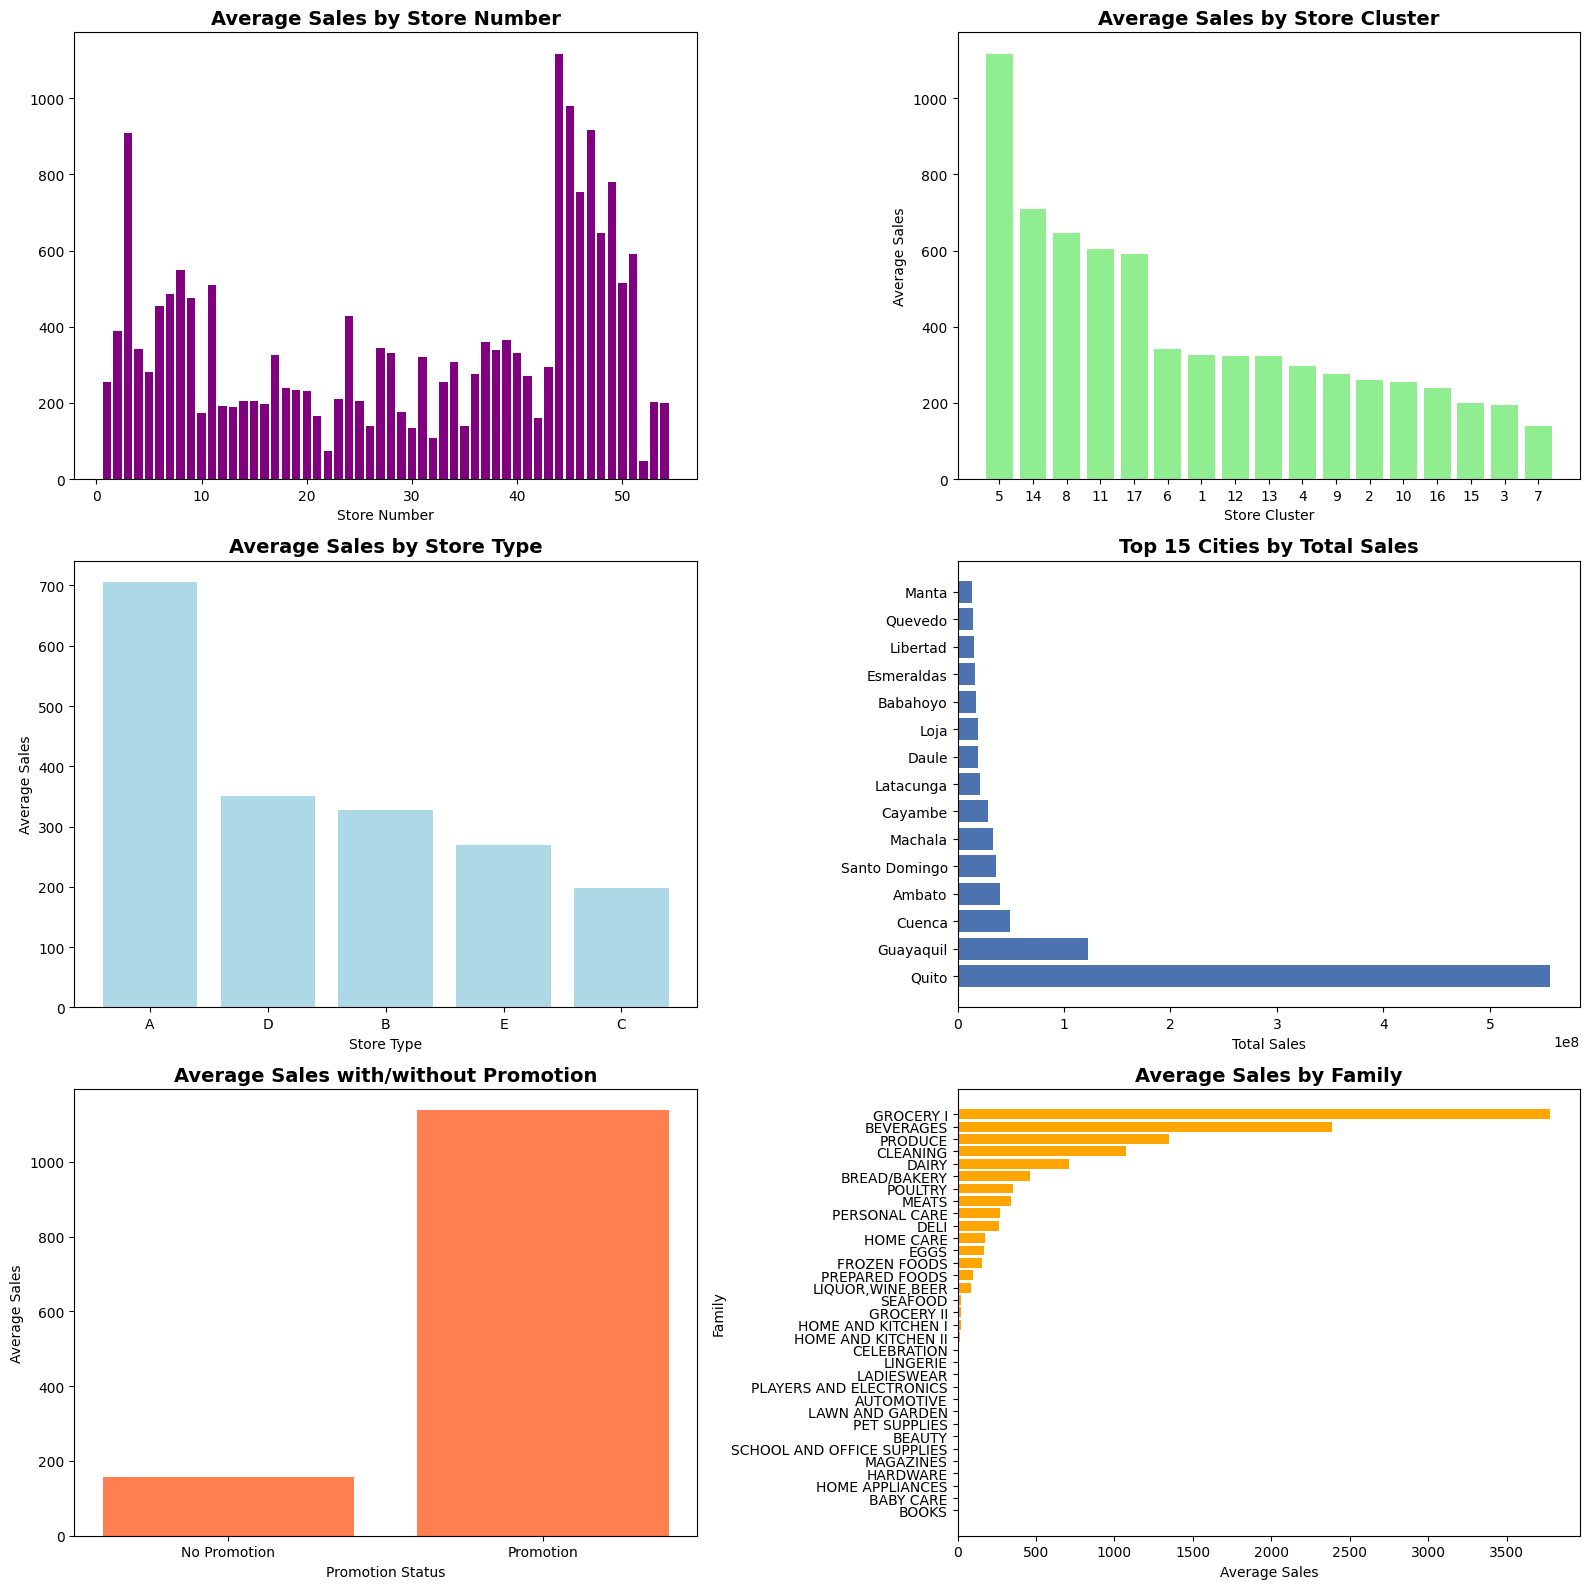

In [6]:
# Sales trends over time
fig, axes = plt.subplots(3, 2, figsize=(16, 16))

# sales by store nbr (from 1 to 54)
store_sales = train_df.groupby('store_nbr')['sales'].mean().sort_values(ascending=False)
axes[0,0].bar(store_sales.index, store_sales.values, color='purple')
axes[0,0].set_title('Average Sales by Store Number', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Store Number')

# Store size distribution (if cluster column exists)
cluster_sales = store_analysis.groupby('cluster')['Avg_Sales'].mean().sort_values(ascending=False)
axes[0,1].bar(cluster_sales.index.astype(str), cluster_sales.values, color='lightgreen')
axes[0,1].set_title('Average Sales by Store Cluster', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Store Cluster')
axes[0,1].set_ylabel('Average Sales')

# Average sales by store type (A,B,C,D,E)
type_sales = store_analysis.groupby('type')['Avg_Sales'].mean().sort_values(ascending=False)
axes[1,0].bar(type_sales.index, type_sales.values, color='lightblue')
axes[1,0].set_title('Average Sales by Store Type', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Store Type')
axes[1,0].set_ylabel('Average Sales')

# Top cities by sales
city_sales = store_analysis.groupby('city')['Total_Sales'].sum().sort_values(ascending=False).head(15)
axes[1,1].barh(range(len(city_sales)), city_sales.values)
axes[1,1].set_yticks(range(len(city_sales)))
axes[1,1].set_yticklabels(city_sales.index)
axes[1,1].set_title('Top 15 Cities by Total Sales', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Total Sales')

# sales by promotion
promo_sales_binary = train_df.groupby(train_df['onpromotion'] > 0)['sales'].mean()
axes[2,0].bar(['No Promotion', 'Promotion'], promo_sales_binary.values, color='coral')
axes[2,0].set_title('Average Sales with/without Promotion', fontsize=14, fontweight='bold')
axes[2,0].set_ylabel('Average Sales')
axes[2,0].set_xlabel('Promotion Status')

# sales by family
family_sales = train_df.groupby('family')['sales'].mean().sort_values(ascending=True)
axes[2,1].barh(family_sales.index, family_sales.values, color='orange')
axes[2,1].set_title('Average Sales by Family', fontsize=14, fontweight='bold')
axes[2,1].set_xlabel('Average Sales')
axes[2,1].set_ylabel('Family')

plt.tight_layout()
plt.show()

## 5. Store Analysis

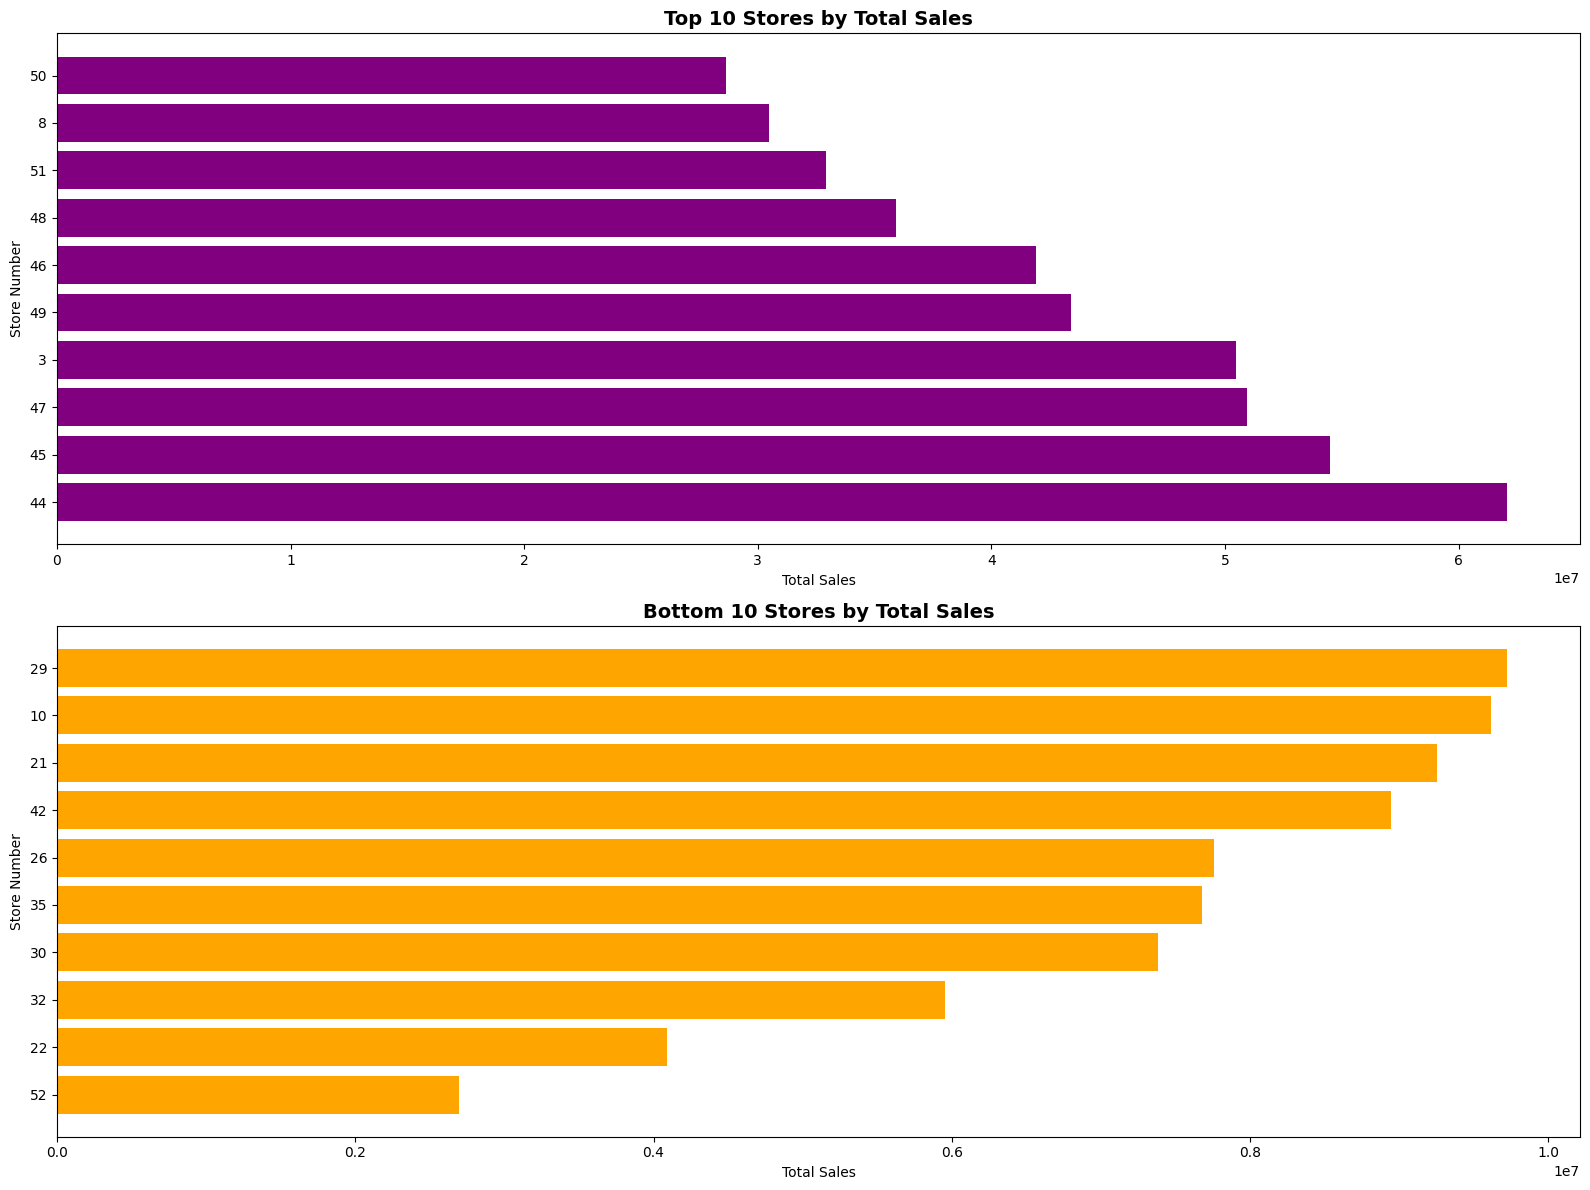

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(16, 12))
# Top 10 stores by total sales
top_10_stores = store_analysis.nlargest(10, 'Total_Sales')
axes[0].barh(top_10_stores['store_nbr'].astype(str), top_10_stores['Total_Sales'], color='purple')
axes[0].set_title('Top 10 Stores by Total Sales', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Total Sales')
axes[0].set_ylabel('Store Number')

# Bottom 10 stores by total sales
bottom_10_stores = store_analysis.nsmallest(10, 'Total_Sales')
axes[1].barh(bottom_10_stores['store_nbr'].astype(str), bottom_10_stores['Total_Sales'], color='orange')
axes[1].set_title('Bottom 10 Stores by Total Sales', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Total Sales')
axes[1].set_ylabel('Store Number')

plt.tight_layout()
plt.show()

## 6. Product Family Analysis

In [8]:
# Product family performance
family_performance = train_df.groupby('family').agg({
    'sales': ['sum', 'mean', 'std', 'count'],
    'onpromotion': 'mean'
}).round(2)

family_performance.columns = ['Total_Sales', 'Avg_Sales', 'Sales_Std', 'Records_Count', 'Promo_Rate']
family_performance = family_performance.reset_index().sort_values('Total_Sales', ascending=False)

print("=== PRODUCT FAMILY ANALYSIS ===")
print(f"Number of product families: {train_df['family'].nunique()}")
print("\nProduct families:")
print(sorted(train_df['family'].unique()))
print("\nTop 15 families by total sales:")
print(family_performance.head(15).to_string(index=False))
print("\nBottom 10 families by total sales:")
print(family_performance.tail(10).to_string(index=False))

=== PRODUCT FAMILY ANALYSIS ===
Number of product families: 33

Product families:
['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', 'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS', 'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES', 'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE', 'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE', 'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY', 'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD']

Top 15 families by total sales:
          family  Total_Sales  Avg_Sales  Sales_Std  Records_Count  Promo_Rate
       GROCERY I 343462734.89    3776.97    2874.21          90936       21.06
       BEVERAGES 216954486.00    2385.79    2307.88          90936        9.97
         PRODUCE 122704684.68    1349.35    2186.48          90936       12.29
        CLEANING  97521289.00    1072.42     734.68          90936        7.27
  

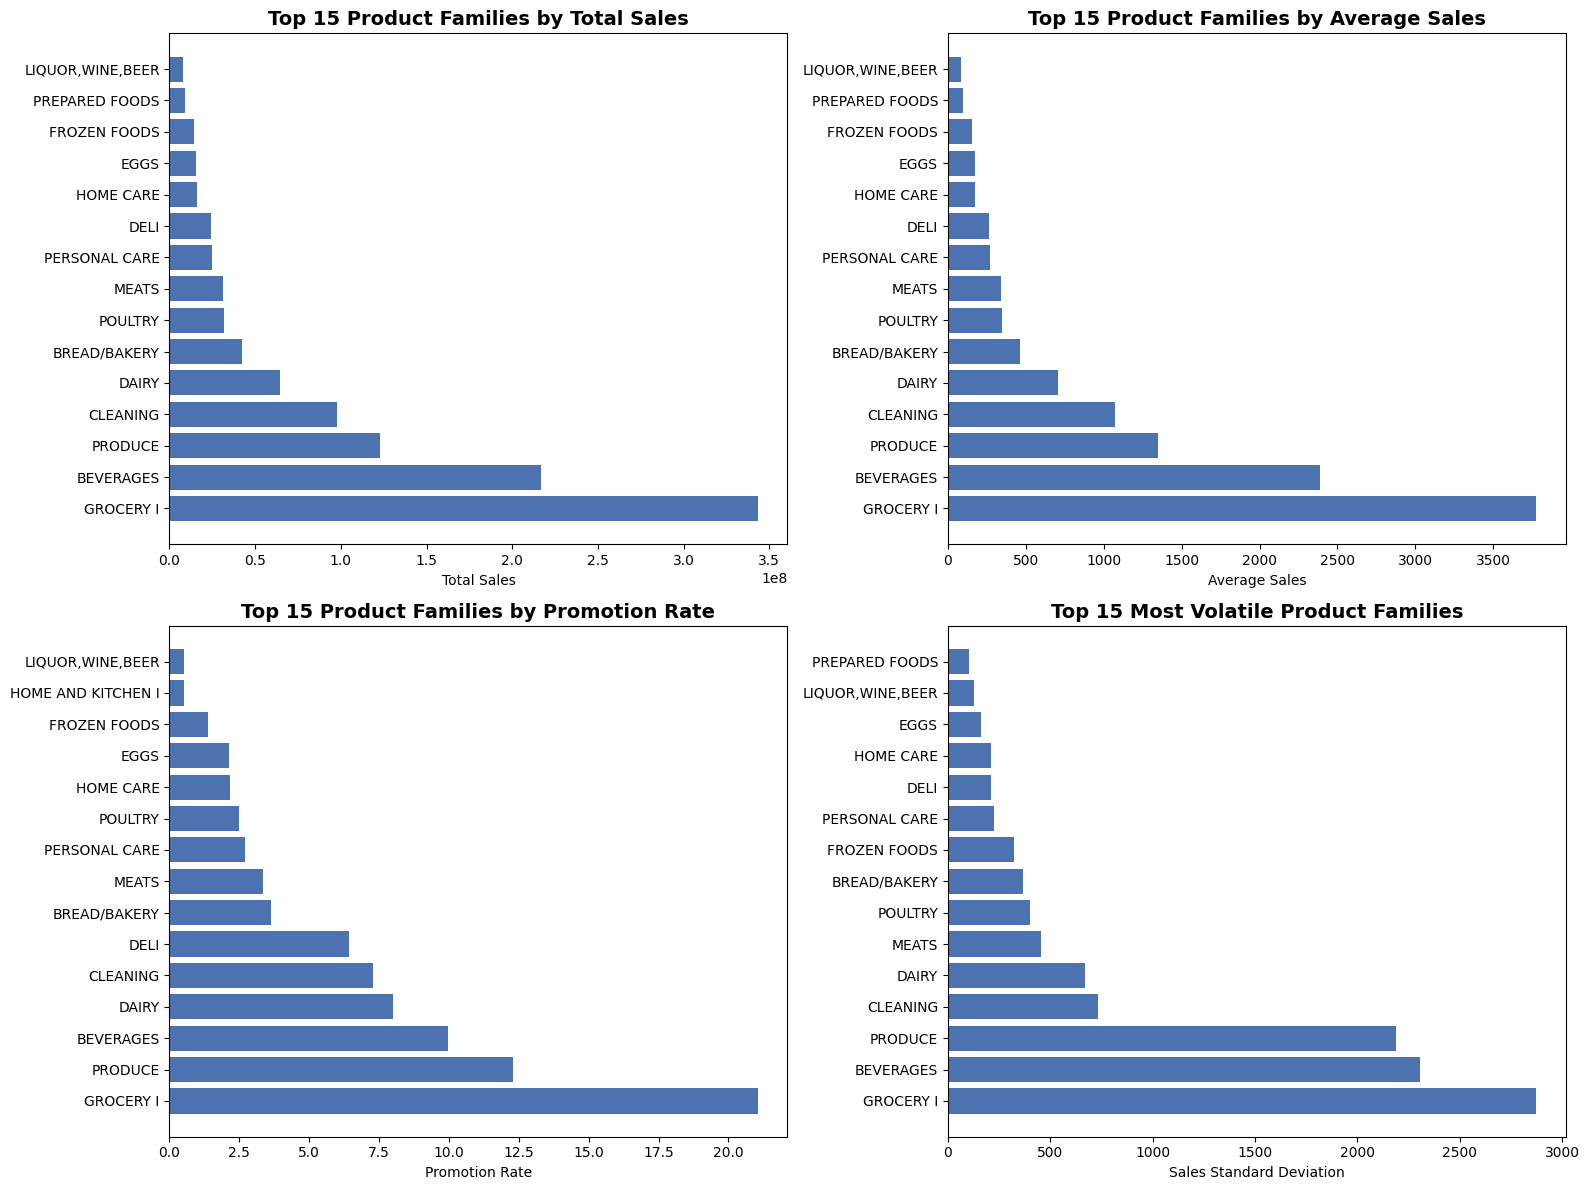

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Top 15 families by total sales
top_families = family_performance.head(15)
axes[0,0].barh(range(len(top_families)), top_families['Total_Sales'])
axes[0,0].set_yticks(range(len(top_families)))
axes[0,0].set_yticklabels(top_families['family'])
axes[0,0].set_title('Top 15 Product Families by Total Sales', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Total Sales')

# Average sales per family
top_avg_families = family_performance.nlargest(15, 'Avg_Sales')
axes[0,1].barh(range(len(top_avg_families)), top_avg_families['Avg_Sales'])
axes[0,1].set_yticks(range(len(top_avg_families)))
axes[0,1].set_yticklabels(top_avg_families['family'])
axes[0,1].set_title('Top 15 Product Families by Average Sales', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Average Sales')

# Promotion rate by family
top_promo_families = family_performance.nlargest(15, 'Promo_Rate')
axes[1,0].barh(range(len(top_promo_families)), top_promo_families['Promo_Rate'])
axes[1,0].set_yticks(range(len(top_promo_families)))
axes[1,0].set_yticklabels(top_promo_families['family'])
axes[1,0].set_title('Top 15 Product Families by Promotion Rate', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Promotion Rate')

# Sales volatility (standard deviation)
volatile_families = family_performance.nlargest(15, 'Sales_Std')
axes[1,1].barh(range(len(volatile_families)), volatile_families['Sales_Std'])
axes[1,1].set_yticks(range(len(volatile_families)))
axes[1,1].set_yticklabels(volatile_families['family'])
axes[1,1].set_title('Top 15 Most Volatile Product Families', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Sales Standard Deviation')

plt.tight_layout()
plt.show()

## 7. Oil Price Analysis and Impact

=== OIL PRICE ANALYSIS ===
Oil data shape: (1218, 2)
Oil price range: 26.19 to 110.62
Missing oil price records: 43 (3.53%)


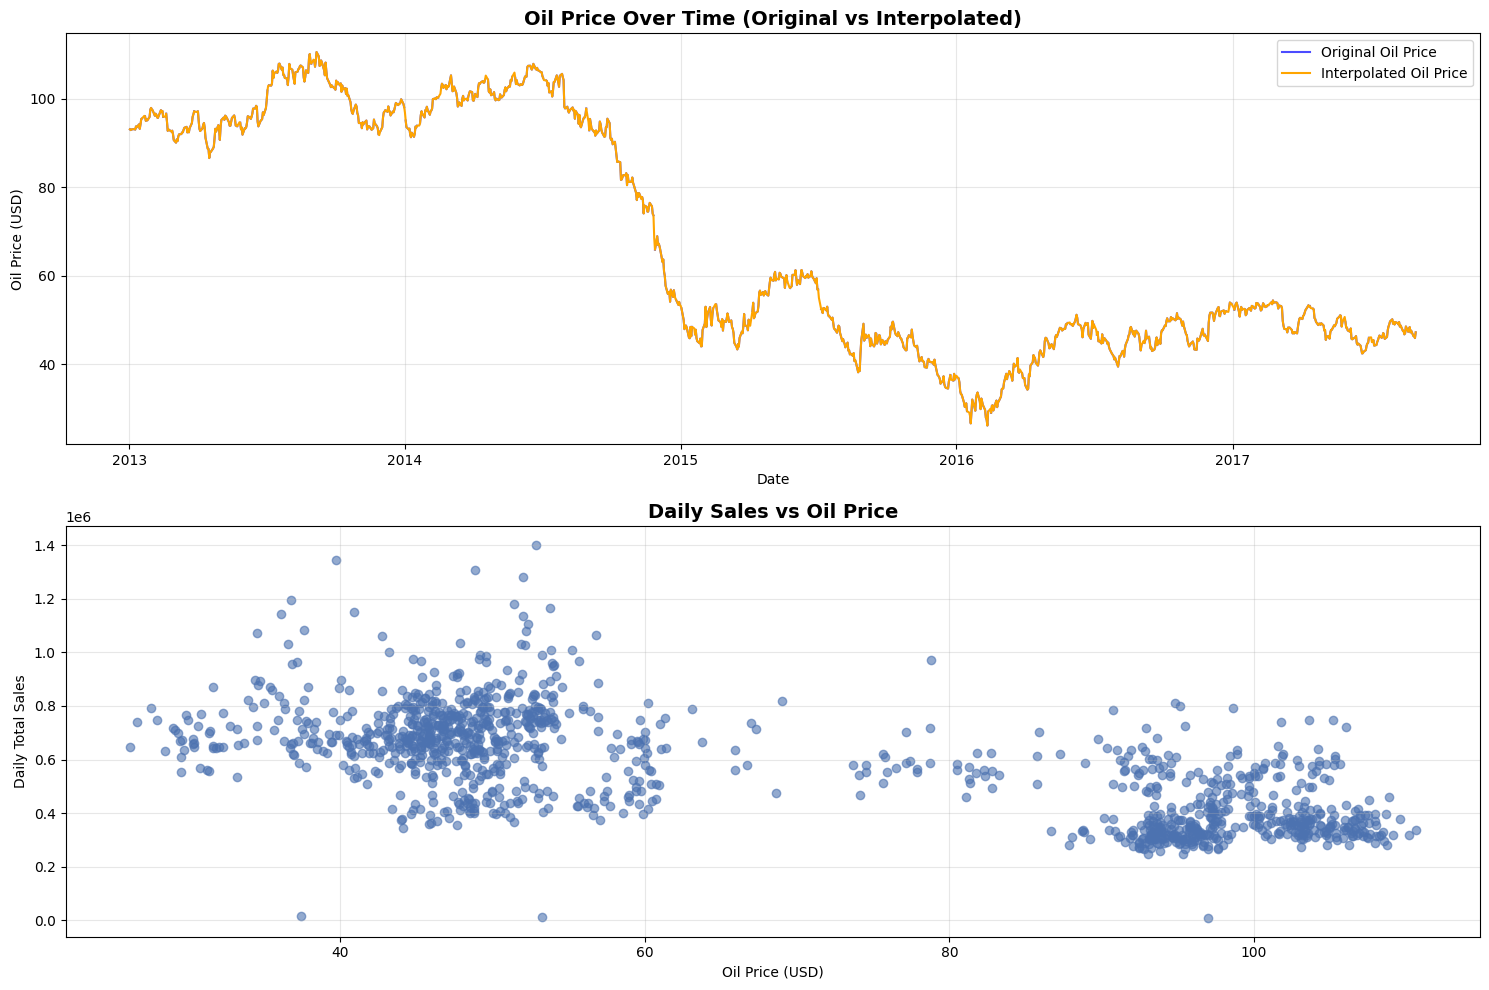


Correlation between oil price and daily sales: -0.6906


In [10]:
# Oil price analysis
print("=== OIL PRICE ANALYSIS ===")
print(f"Oil data shape: {oil_df.shape}")
print(f"Oil price range: {oil_df['dcoilwtico'].min():.2f} to {oil_df['dcoilwtico'].max():.2f}")
print(f"Missing oil price records: {oil_df['dcoilwtico'].isnull().sum()} ({oil_df['dcoilwtico'].isnull().mean()*100:.2f}%)")

# Interpolate missing values in oil prices
oil_df['interpolated_dcoilwtico'] = oil_df['dcoilwtico'].interpolate(method='polynomial', order=4)

# Visualize oil price trends
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Original vs interpolated oil prices
axes[0].plot(oil_df['date'], oil_df['dcoilwtico'], label='Original Oil Price', alpha=0.7, color='blue')
axes[0].plot(oil_df['date'], oil_df['interpolated_dcoilwtico'], label='Interpolated Oil Price', color='orange')
axes[0].set_title('Oil Price Over Time (Original vs Interpolated)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Oil Price (USD)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Merge oil data with sales data for correlation analysis
daily_sales_oil = train_df.groupby('date')['sales'].sum().reset_index()
sales_oil_merged = daily_sales_oil.merge(oil_df[['date', 'interpolated_dcoilwtico']], on='date', how='left')

# Sales vs Oil price scatter plot
axes[1].scatter(sales_oil_merged['interpolated_dcoilwtico'], sales_oil_merged['sales'], alpha=0.6)
axes[1].set_title('Daily Sales vs Oil Price', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Oil Price (USD)')
axes[1].set_ylabel('Daily Total Sales')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate correlation
correlation = sales_oil_merged['sales'].corr(sales_oil_merged['interpolated_dcoilwtico'])
print(f"\nCorrelation between oil price and daily sales: {correlation:.4f}")

## 8. Holidays and Events Analysis

=== HOLIDAYS AND EVENTS ANALYSIS ===
Holidays data shape: (350, 6)

Holiday types:
type
Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: count, dtype: int64

Holiday description examples:
description
Carnaval                         10
Fundacion de Ibarra               7
Fundacion de Cuenca               7
Cantonizacion de Libertad         6
Cantonizacion de Riobamba         6
Cantonizacion del Puyo            6
Fundacion de Manta                6
Cantonizacion de Guaranda         6
Provincializacion de Imbabura     6
Fundacion de Machala              6
Name: count, dtype: int64

=== HOLIDAY IMPACT ON SALES ===
               mean  median           sum    count
Non-Holiday  352.16    11.0  8.986482e+08  2551824
Holiday      389.69    12.0  1.749967e+08   449064


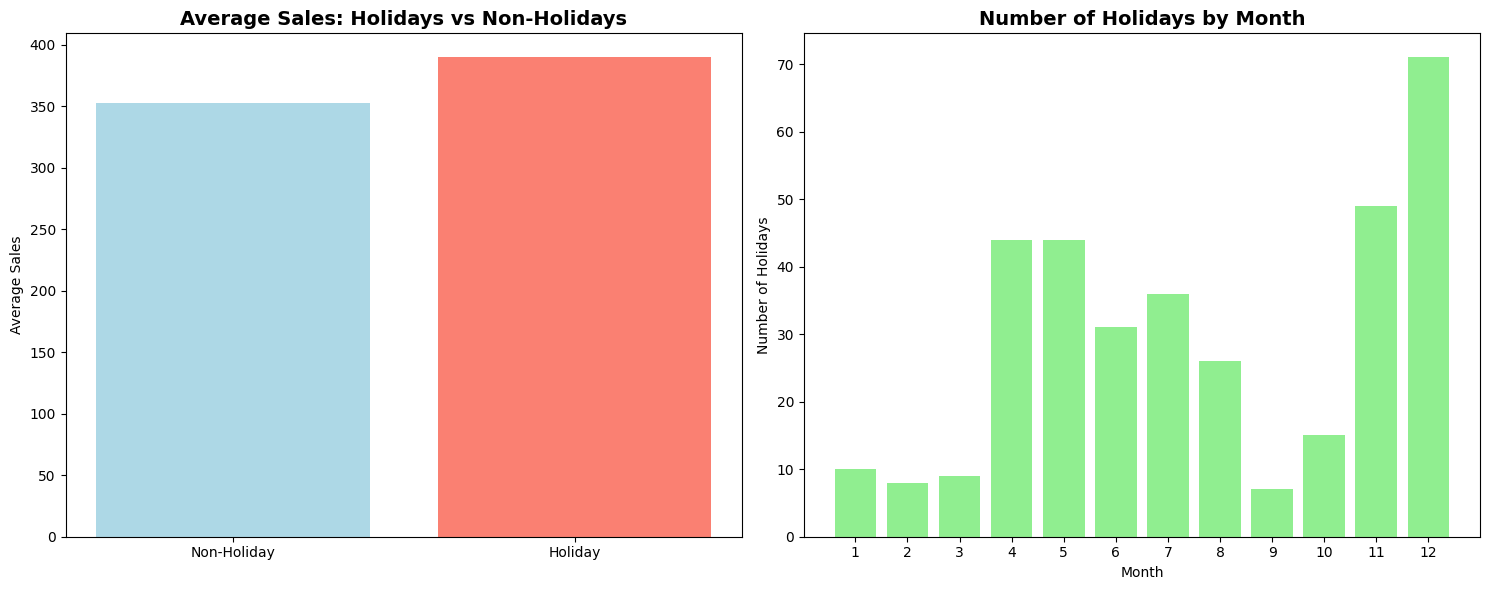


Holiday effect: 1.11x higher average sales on holidays


In [11]:
print("=== HOLIDAYS AND EVENTS ANALYSIS ===")
print(f"Holidays data shape: {holiday_df.shape}")
print("\nHoliday types:")
print(holiday_df['type'].value_counts())
print("\nHoliday description examples:")
print(holiday_df['description'].value_counts().head(10))

# Create holiday indicator in sales data
train_df['is_holiday'] = train_df['date'].isin(holiday_df['date']).astype(int)

# Compare sales on holidays vs non-holidays
holiday_impact = train_df.groupby('is_holiday')['sales'].agg(['mean', 'median', 'sum', 'count']).round(2)
holiday_impact.index = ['Non-Holiday', 'Holiday']

print("\n=== HOLIDAY IMPACT ON SALES ===")
print(holiday_impact)

# Visualize holiday impact
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Average sales comparison
axes[0].bar(['Non-Holiday', 'Holiday'], holiday_impact['mean'], color=['lightblue', 'salmon'])
axes[0].set_title('Average Sales: Holidays vs Non-Holidays', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Average Sales')

# Monthly holiday distribution
holiday_df['month'] = holiday_df['date'].dt.month
monthly_holidays = holiday_df['month'].value_counts().sort_index()
axes[1].bar(monthly_holidays.index, monthly_holidays.values, color='lightgreen')
axes[1].set_title('Number of Holidays by Month', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Number of Holidays')
axes[1].set_xticks(range(1, 13))

plt.tight_layout()
plt.show()

holiday_effect = holiday_impact.loc['Holiday', 'mean'] / holiday_impact.loc['Non-Holiday', 'mean']
print(f"\nHoliday effect: {holiday_effect:.2f}x {'higher' if holiday_effect > 1 else 'lower'} average sales on holidays")

## 9. Transactions Analysis

=== TRANSACTIONS ANALYSIS ===
Transactions data shape: (83488, 3)
Transaction count range: 5 to 8359
Average transactions per store per day: 1694.60

Average sales per transaction: $7.46
Median sales per transaction: $7.16


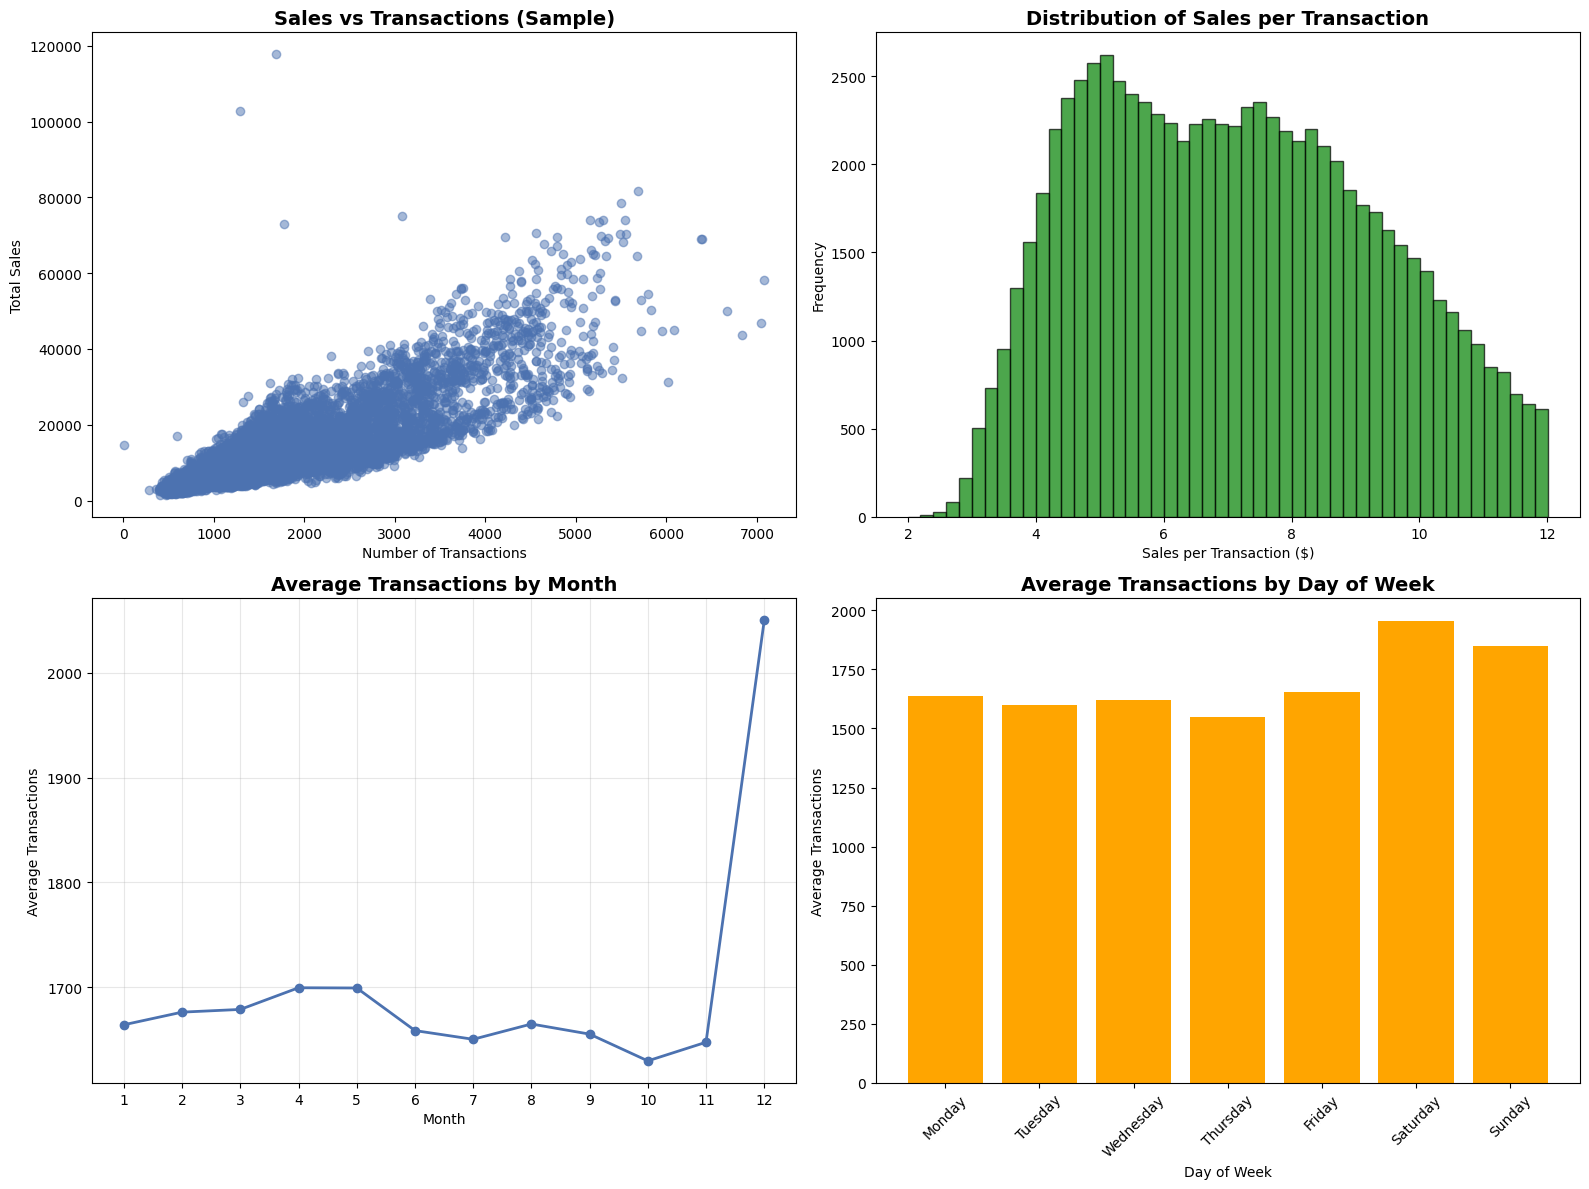


Correlation between sales and transactions: 0.8374


In [12]:
print("=== TRANSACTIONS ANALYSIS ===")
print(f"Transactions data shape: {transactions_df.shape}")
print(f"Transaction count range: {transactions_df['transactions'].min()} to {transactions_df['transactions'].max()}")
print(f"Average transactions per store per day: {transactions_df['transactions'].mean():.2f}")

# Merge transactions with sales data for analysis
daily_store_sales = train_df.groupby(['date', 'store_nbr'])['sales'].sum().reset_index()
sales_transactions = daily_store_sales.merge(transactions_df, on=['date', 'store_nbr'], how='inner')

# Calculate sales per transaction
sales_transactions['sales_per_transaction'] = sales_transactions['sales'] / sales_transactions['transactions']
sales_transactions['sales_per_transaction'] = sales_transactions['sales_per_transaction'].replace([np.inf, -np.inf], np.nan)

print(f"\nAverage sales per transaction: ${sales_transactions['sales_per_transaction'].mean():.2f}")
print(f"Median sales per transaction: ${sales_transactions['sales_per_transaction'].median():.2f}")

# Visualize transactions analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Sales vs Transactions scatter plot
sample_data = sales_transactions.sample(n=min(10000, len(sales_transactions)))  # Sample for performance
axes[0,0].scatter(sample_data['transactions'], sample_data['sales'], alpha=0.5)
axes[0,0].set_title('Sales vs Transactions (Sample)', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Number of Transactions')
axes[0,0].set_ylabel('Total Sales')

# Sales per transaction distribution
valid_spt = sales_transactions['sales_per_transaction'].dropna()
valid_spt = valid_spt[(valid_spt > 0) & (valid_spt < valid_spt.quantile(0.95))]  # Remove outliers
axes[0,1].hist(valid_spt, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[0,1].set_title('Distribution of Sales per Transaction', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Sales per Transaction ($)')
axes[0,1].set_ylabel('Frequency')

# Monthly transaction trends
monthly_transactions = transactions_df.copy()
monthly_transactions['month'] = monthly_transactions['date'].dt.month
monthly_trans_avg = monthly_transactions.groupby('month')['transactions'].mean()
axes[1,0].plot(monthly_trans_avg.index, monthly_trans_avg.values, marker='o', linewidth=2)
axes[1,0].set_title('Average Transactions by Month', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Month')
axes[1,0].set_ylabel('Average Transactions')
axes[1,0].set_xticks(range(1, 13))
axes[1,0].grid(True, alpha=0.3)

# Day of week transaction patterns
transactions_df['dayofweek'] = transactions_df['date'].dt.dayofweek
dow_transactions = transactions_df.groupby('dayofweek')['transactions'].mean()
axes[1,1].bar(range(len(dow_transactions)), dow_transactions.values, color='orange')
axes[1,1].set_title('Average Transactions by Day of Week', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Day of Week')
axes[1,1].set_ylabel('Average Transactions')
axes[1,1].set_xticks(range(7))
axes[1,1].set_xticklabels(day_names, rotation=45)

plt.tight_layout()
plt.show()

# Correlation between sales and transactions
correlation_sales_trans = sales_transactions['sales'].corr(sales_transactions['transactions'])
print(f"\nCorrelation between sales and transactions: {correlation_sales_trans:.4f}")

## 10. Correlation Analysis

In [ ]:
# Create a correlation dataset
corr_data = train_df[['sales', 'onpromotion', 'year', 'month', 'dayofweek', 'quarter', 'is_holiday']].copy()

# Calculate correlation matrix
correlation_matrix = corr_data.corr()

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Key Variables', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("=== CORRELATION INSIGHTS ===")
sales_correlations = correlation_matrix['sales'].sort_values(ascending=False)
print("Correlations with sales:")
for var, corr in sales_correlations.items():
    if var != 'sales':
        print(f"{var}: {corr:.4f}")

KeyError: "['quarter'] not in index"

## 11. Key Insights and Recommendations

In [ ]:
print("="*60)
print("🔍 COMPREHENSIVE EDA INSIGHTS & RECOMMENDATIONS")
print("="*60)

print("\n📊 DATASET OVERVIEW:")
print(f"• Total records: {len(train_df):,}")
print(f"• Date range: {train_df['date'].min().strftime('%Y-%m-%d')} to {train_df['date'].max().strftime('%Y-%m-%d')}")
print(f"• Number of stores: {train_df['store_nbr'].nunique()}")
print(f"• Number of product families: {train_df['family'].nunique()}")
print(f"• Total sales volume: ${train_df['sales'].sum():,.2f}")

print("\n📈 TEMPORAL PATTERNS:")
best_month = train_df.groupby('month')['sales'].mean().idxmax()
worst_month = train_df.groupby('month')['sales'].mean().idxmin()
best_dow = train_df.groupby('day_name')['sales'].mean().idxmax()
worst_dow = train_df.groupby('day_name')['sales'].mean().idxmin()

print(f"• Peak sales month: {best_month} (consider seasonal inventory planning)")
print(f"• Lowest sales month: {worst_month} (opportunity for promotions)")
print(f"• Best performing day: {best_dow}")
print(f"• Weakest performing day: {worst_dow}")

print("\n🏪 STORE PERFORMANCE:")
top_store = store_analysis.loc[store_analysis['Total_Sales'].idxmax(), 'store_nbr']
worst_store = store_analysis.loc[store_analysis['Total_Sales'].idxmin(), 'store_nbr']
print(f"• Best performing store: #{top_store}")
print(f"• Underperforming store: #{worst_store} (needs attention)")
print(f"• Store performance varies significantly (coefficient of variation: {store_analysis['Total_Sales'].std()/store_analysis['Total_Sales'].mean():.2f})")

print("\n🛍️ PRODUCT INSIGHTS:")
top_family = family_performance.iloc[0]['family']
most_promoted = family_performance.loc[family_performance['Promo_Rate'].idxmax(), 'family']
print(f"• Top selling product family: {top_family}")
print(f"• Most promoted family: {most_promoted}")

promo_effect = train_df.groupby('onpromotion')['sales'].mean()
promo_impact = promo_effect[1] / promo_effect[0]
print(f"• Promotion effectiveness: {promo_impact:.2f}x increase in average sales")

print("\n🎄 SEASONAL & EXTERNAL FACTORS:")
if 'is_holiday' in train_df.columns:
    holiday_effect = train_df.groupby('is_holiday')['sales'].mean()
    holiday_impact = holiday_effect[1] / holiday_effect[0] if len(holiday_effect) > 1 else 1
    print(f"• Holiday impact: {holiday_impact:.2f}x {'increase' if holiday_impact > 1 else 'decrease'} in sales")

oil_corr = sales_oil_merged['sales'].corr(sales_oil_merged['interpolated_dcoilwtico'])
print(f"• Oil price correlation: {oil_corr:.3f} ({'positive' if oil_corr > 0 else 'negative'} relationship)")

print("\n💡 STRATEGIC RECOMMENDATIONS:")
print("1. 📅 TIMING OPTIMIZATION:")
print(f"   • Focus marketing efforts during month {best_month}")
print(f"   • Increase promotions during month {worst_month}")
print(f"   • Optimize staffing for {best_dow}s")

print("\n2. 🏬 STORE MANAGEMENT:")
print(f"   • Analyze best practices from store #{top_store}")
print(f"   • Provide support/training for store #{worst_store}")
print("   • Consider store clustering for targeted strategies")

print("\n3. 📦 INVENTORY & PROMOTIONS:")
print(f"   • Prioritize inventory for {top_family} products")
if promo_impact > 1.5:
    print("   • Promotions are highly effective - consider expanding")
elif promo_impact < 1.2:
    print("   • Promotions show limited impact - review strategy")
print("   • Coordinate promotions with holidays and peak seasons")

print("\n4. 🔮 FORECASTING CONSIDERATIONS:")
print("   • Include temporal features (month, day of week, holidays)")
print("   • Consider external factors (oil prices, economic indicators)")
print("   • Account for promotion effects in demand planning")
print("   • Implement store and product family specific models")

zero_sales_pct = (train_df['sales'] == 0).mean() * 100
print(f"\n⚠️ DATA QUALITY NOTES:")
print(f"   • {zero_sales_pct:.1f}% of records have zero sales (normal for closed days/low demand)")
if train_df['sales'].min() < 0:
    print("   • Negative sales present (likely returns - consider separate modeling)")
print("   • Oil price data has gaps - interpolation applied")

print("\n" + "="*60)
print("EDA COMPLETE - Ready for Feature Engineering & Modeling! 🚀")
print("="*60)

🔍 COMPREHENSIVE EDA INSIGHTS & RECOMMENDATIONS

📊 DATASET OVERVIEW:
• Total records: 3,000,888
• Date range: 2013-01-01 to 2017-08-15
• Number of stores: 54
• Number of product families: 33
• Total sales volume: $1,073,644,952.20

📈 TEMPORAL PATTERNS:
• Peak sales month: 12 (consider seasonal inventory planning)
• Lowest sales month: 2 (opportunity for promotions)
• Best performing day: Sunday
• Weakest performing day: Thursday

🏪 STORE PERFORMANCE:
• Best performing store: #44
• Underperforming store: #52 (needs attention)
• Store performance varies significantly (coefficient of variation: 0.67)

🛍️ PRODUCT INSIGHTS:
• Top selling product family: GROCERY I
• Most promoted family: GROCERY I
• Promotion effectiveness: 2.95x increase in average sales

🎄 SEASONAL & EXTERNAL FACTORS:
• Holiday impact: 1.11x increase in sales
• Oil price correlation: -0.691 (negative relationship)

💡 STRATEGIC RECOMMENDATIONS:
1. 📅 TIMING OPTIMIZATION:
   • Focus marketing efforts during month 12
   • Incre